# Consistency check with $T_{\rm{X}}$ and $L_{\rm{X}}$ measured from Chandra data

## Import Statements

In [164]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
import os
from shutil import rmtree, copyfile
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

from regions import CircleSkyRegion, CirclePixelRegion, Regions, PixCoord, CircleAnnulusSkyRegion
from ciao_contrib.runtool import specextract

import xga
# This just sets the number of cores this analysis is allowed to use - IRRELEVANT HERE REALLY AS XGA DOESN'T SUPPORT CHANDRA YET
xga.NUM_CORES = 5
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/lum_temp_rad_pipeline')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.utils import xmm_sky
from xga.samples import ClusterSample
from xga.products import Image, ExpMap, RateMap, Spectrum
from xga.imagetools.misc import sky_deg_scale
from xga import BASE_XSPEC_SCRIPT, XGA_EXTRACT

%matplotlib inline

## Setting up directories

Need to make sure that some of the directories that we will be storing output files and figures in actually exist:

In [2]:
# This is where we store the region files output to make the Chandra spectral generation easier
if not os.path.exists('../../outputs/reg_files/'):
    os.makedirs('../../outputs/reg_files/')

## Setting up useful functions

This is mainly for the XSPEC script setup function - which is functionally identical to the XGA `single_temp_apec()` function, but adapted to avoid using XGA sources and to use the Chandra spectra generated in this analysis. This is only necessary because Chandra support in XGA is early in development, and isn't yet ready for use:

In [145]:
def gen_xspec_script(source, spec_objs, script_out, start_temp=Quantity(3, 'keV'), freeze_met=True, freeze_temp=False, 
                     freeze_nh=True, spectrum_checking=True, lo_en=Quantity(0.4, 'keV'), hi_en=Quantity(7.0, 'keV'), 
                     lum_en: Quantity = Quantity([[0.5, 2.0], [0.01, 100.0]], "keV")):
    model = "constant*tbabs*apec"
    par_names = "{factor nH kT Abundanc Redshift norm}"
    lum_low_lims = "{" + " ".join(lum_en[:, 0].to("keV").value.astype(str)) + "}"
    lum_upp_lims = "{" + " ".join(lum_en[:, 1].to("keV").value.astype(str)) + "}"

    specs = "{" + " ".join([spec.path for spec in spec_objs]) + "}"
    
    # Whatever start temperature is passed gets converted to keV, this will be put in the template
    t = start_temp.to("keV", equivalencies=u.temperature_energy()).value
    # Another TCL list, this time of the parameter start values for this model.
    par_values = "{{{0} {1} {2} {3} {4} {5}}}".format(1., source.nH.to("10^22 cm^-2").value, t, 0.3,
                                                      source.redshift, 1.)

    # Set up the TCL list that defines which parameters are frozen, dependent on user input - this can now
    #  include the temperature, if the user wants it fixed at the start value
    freezing = "{{F {n} {t} {a} T F}}".format(n="T" if freeze_nh else "F",
                                              t="T" if freeze_temp else "F",
                                              a="T" if freeze_met else "F")

    # Set up the TCL list that defines which parameters are linked across different spectra, only the
    #  multiplicative constant that accounts for variation in normalisation over different observations is not
    #  linked
    linking = "{F T T T T T}"

    # If the user wants the spectrum cleaning step to be run, then we have to set up some acceptable
    #  limits. For this function they will be hardcoded, for simplicities' sake, and we're only going to
    #  check the temperature, as it's the main thing we're fitting for with constant*tbabs*apec
    if spectrum_checking:
        check_list = "{kT}"
        check_lo_lims = "{0.01}"
        check_hi_lims = "{20}"
        check_err_lims = "{15}"
    else:
        check_list = "{}"
        check_lo_lims = "{}"
        check_hi_lims = "{}"
        check_err_lims = "{}"

    # This sets the list of parameter IDs which should be zeroed at the end to calculate unabsorbed
    #  luminosities. I am only specifying parameter 2 here (though there will likely be multiple models
    #  because there are likely multiple spectra) because I know that nH of tbabs is linked in this
    #  setup, so zeroing one will zero them all.
    nh_to_zero = "{2}"

    # Read in the template file for the XSPEC script.
    with open(BASE_XSPEC_SCRIPT, 'r') as x_script:
        script = x_script.read()

    dest_dir = os.path.dirname(script_out)
    out_file = os.path.join(dest_dir, os.path.basename(script_out)[:-4] + "_constant*tbabs*apec_fit_results")

    # The template is filled out here, taking everything we have generated and everything the user
    #  passed in. The result is an XSPEC script that can be run as is.
    script = script.format(xsp=XGA_EXTRACT, ab='angr', md="leven", H0=source.cosmo.H0.value,
                           q0=0., lamb0=source.cosmo.Ode0, sp=specs, lo_cut=lo_en.to("keV").value,
                           hi_cut=hi_en.to("keV").value, m=model, pn=par_names, pv=par_values,
                           lk=linking, fr=freezing, el=1, lll=lum_low_lims, lul=lum_upp_lims,
                           of=out_file, redshift=source.redshift, lel=68, check=spectrum_checking, cps=check_list,
                           cpsl=check_lo_lims, cpsh=check_hi_lims, cpse=check_err_lims, ns=True,
                           nhmtz=nh_to_zero)

    # Write out the filled-in template to its destination
    with open(script_out, 'w') as xcm:
        xcm.write(script)


## Reading the XGA sample/results files from XMM analysis

We read in the files generated by our various runs of the XGA-LTR in another notebook in this repository. They contain the radii we measured, as well as other useful information - we're going to use Chandra to measure properties within the XMM defined radii (for the limited groups that have Chandra coverage):

In [3]:
r500_samp = pd.read_csv('../../outputs/results/ltr_r500_pipeline_results.csv')
r500_froztemp_samp = pd.read_csv('../../outputs/results/ltr_r500_froztemp_pipeline_results.csv')

r2500_samp = pd.read_csv('../../outputs/results/ltr_r2500_pipeline_results.csv')
r2500_froztemp_samp = pd.read_csv('../../outputs/results/ltr_r2500_froztemp_pipeline_results.csv')

As previously stated, few of our groups have usable Chandra coverage, so we'll cut down the results files to leave only the relevant entries:

In [4]:
with_ch_names = ['12833A', '12833B', 'J215504.8-093520', 'J215437.2-091532.4']

r500_samp = r500_samp[r500_samp['name'].isin(with_ch_names)]
r500_froztemp_samp = r500_froztemp_samp[r500_froztemp_samp['name'].isin(with_ch_names)]

r2500_samp = r2500_samp[r2500_samp['name'].isin(with_ch_names)]
r2500_froztemp_samp = r2500_froztemp_samp[r2500_froztemp_samp['name'].isin(with_ch_names)]

As an illustration of the contents of one of these files:

In [5]:
r500_samp

,name,ra,dec,redshift,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
9,12833A,129.49680,44.248700,0.145,484.161429,22.267250,1.394590,0.098024,0.113226,3.419655e+42,4.326240e+41,2.991426e+41,6.828256e+42,9.969550e+41,7.096560e+41,1.416080,0.145301,0.239000,2.240773e+42,3.645432e+41,2.770394e+41,4.498901e+42,7.032202e+41,5.884023e+41
10,12833B,129.44500,44.379000,0.145,435.477156,26.364544,1.161630,0.135227,0.116765,2.511945e+42,2.677573e+41,3.283677e+41,4.654556e+42,7.296128e+41,8.407739e+41,0.926943,0.120020,0.134047,1.378771e+42,3.555113e+41,3.233896e+41,2.309754e+42,5.456964e+41,3.761557e+41
13,J215504.8-093520,328.76992,-9.588805,0.077,581.016969,20.416613,1.727820,0.077037,0.089383,7.789182e+42,2.873907e+41,4.574905e+41,1.769054e+43,1.037285e+42,8.310896e+41,1.708510,0.101667,0.138426,4.889413e+42,3.539555e+41,4.222563e+41,1.106974e+43,9.531763e+41,8.356995e+41
14,J215437.2-091532.4,328.65500,-9.259000,0.078,393.970353,18.283530,0.350344,0.021447,0.024195,4.768932e+40,4.768932e+40,5.223045e+43,8.846684e+40,8.846684e+40,7.043529e+43,0.335890,0.016225,0.023720,1.039277e+43,4.677879e+41,4.965552e+41,2.661767e+43,1.319874e+42,1.311632e+42


## Setting up an XGA ClusterSample

Unlike our overall XMM analysis, we will not be using XGA to measure temperatures and luminosities from Chandra observations - this is because Chandra support is still early in development. We will still declare a ClusterSample however, simply because it will extract nH values for us, and may help set up some of the arguments for Chandra specextract and the eventual XSPEC fits:

In [6]:
srcs = ClusterSample(r500_samp['ra'].values, r500_samp['dec'].values, r500_samp['redshift'].values, 
                     r500_samp['name'].values, r500=Quantity(r500_samp['r500'].values, 'kpc'), 
                     use_peak=False, load_fits=True, clean_obs=False)
srcs.info()
srcs.suppressed_warnings

Setting up Galaxy Clusters: 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


-----------------------------------------------------
Number of Sources - 4
Redshift Information - True
Sources with ≥1 detection - 4 [100%]
-----------------------------------------------------




/mnt/home/turne540/software/anaconda3/envs/chandra_daxa_dev/lib/python3.11/site-packages/xga/samples/extended.py:279: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


{'J215504.8-093520': ["J215504.8-093520 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data"],
 'J215437.2-091532.4': ['A PSF sized extended source has been detected in 0204310101 and is very close to the user supplied coordinates of J215437.2-091532.4. It will not be excluded from analysis due to the possibility of a mis-identified cool core']}

## Defining which Chandra observations are relevant for each group

As we don't have an XGA ClusterSample to do this for us, we previously examined the Chandra obserations and identified which are relevant to each of the groups - here this information is placed in a dictionary so that it can be accessed programmatically: 

In [7]:
rel_ch_obs = {'12833A': ['15378'], 
              '12833B': ['15378'], 
              'J215504.8-093520': ['2957', '2958'], 
              'J215437.2-091532.4': ['2957', '2958']}

Temporary notes of what specextract is going to want:

specextract  infile outroot [bkgfile] [asp] [dtffile] [mskfile]
[rmffile] [badpixfile] [dafile] [bkgresp] [weight] [weight_rmf]
[resp_pos] [refcoord] [correctpsf] [combine] [readout_streakspec]
[grouptype] [binspec] [bkg_grouptype] [bkg_binspec] [energy] [channel]
[energy_wmap] [binarfcorr] [binwmap] [binarfwmap] [parallel] [nproc]
[tmpdir] [clobber] [verbose]


## Generating Chandra spectra

### Setting up useful values

In [96]:
root_pth = "../../data/archives/OVIGroups/processed_data/chandra/{oi}/"
evt_pth = os.path.join(root_pth, "events/obsid{oi}-instACIS-subexpE001-en-cleanevents.fits")
im_pth = os.path.join(root_pth, "images/obsid{oi}-instACIS-subexpE001-en0.5_7.0keV-image.fits")
ex_pth = os.path.join(root_pth, "images/obsid{oi}-instACIS-subexpE001-en0.5_7.0keV-expmap.fits")

r500_inn_bck_fac = 1.05
r500_out_bck_fac = 1.5

# Controls the binning applied to the spectra
min_counts = 25

### Loading in images

This step might seem unnecessary for the generation of spectra, but any extraction or contaminant regions that we define will have to be put into the Chandra 'sky' coordinate system (the tools will not accept RA-Dec regions) - an easy-ish way to do that conversion is to use an XGA image's coordinate conversion functionality:

In [150]:
rel_ch_rts = {src_name: {} for src_name in rel_ch_obs}
for src_name in rel_ch_obs:
    rel_src = srcs[src_name]
    rel_ois = rel_ch_obs[src_name]
    
    for oi in rel_ois:
        cur_im_pth = im_pth.format(oi=oi)        
        cur_im = Image(cur_im_pth, oi, 'ACIS', "", "", "", Quantity(0.5, 'keV'), Quantity(7.0, 'keV'))

        cur_ex_pth = ex_pth.format(oi=oi)
        cur_ex = ExpMap(cur_ex_pth, oi, 'ACIS', "", "", "", Quantity(0.5, 'keV'), Quantity(7.0, 'keV'))

        cur_rt = RateMap(cur_im, cur_ex)
        rel_ch_rts[src_name][oi] = cur_rt
        cur_rt.src_name = src_name
        # cur_rt.view(rel_src.ra_dec)

### Setting up regions

In [190]:
rel_ch_reg_files = {src_name: {} for src_name in rel_ch_obs}
rel_ch_radec_reg_files = {src_name: {} for src_name in rel_ch_obs}

for src_name in rel_ch_obs:
    rel_src = srcs[src_name]
    radec_coord = SkyCoord(*rel_src.ra_dec)
    cur_r500_deg = rel_src.get_radius('r500', 'deg')

    cur_r500_bck_inn = cur_r500_deg * r500_inn_bck_fac
    cur_r500_bck_out = cur_r500_deg * r500_out_bck_fac

    rel_ois = rel_ch_obs[src_name]
    for oi in rel_ois:
        cur_rt = rel_ch_rts[src_name][oi]
        # Ignore the 'xmm_sky' units - this version of XGA is optimised for XMM data, this is really Chandra Sky coords
        sky_coord = PixCoord(*cur_rt.coord_conv(rel_src.ra_dec, 'xmm_sky').value)
        sky_to_deg = sky_deg_scale(cur_rt, rel_src.ra_dec, )
        sky_rad = (cur_r500_deg / sky_to_deg).to(xmm_sky)

        sky_bck_inn_rad = (cur_r500_bck_inn / sky_to_deg).to(xmm_sky)
        sky_bck_out_rad = (cur_r500_bck_out / sky_to_deg).to(xmm_sky)
        
        reg_file = src_name + "-chandra-obsid{}".format(oi) + '-r500.reg'
        r500_reg_out = os.path.join('../../outputs/reg_files/', reg_file)

        # Unfortunately the regions module saving functionality doesn't include the CIAO format - functionally seems
        #  identical to DS9 (from my small exploration at least) but the first line is different. As such I'll 
        #  write it out manually
        with open(r500_reg_out, 'w') as reggo:
            reggo.write("# Region file format: CIAO version 1.0\n")
            reggo.write("circle({x},{y},{r})".format(x=sky_coord.x, y=sky_coord.y, r=sky_rad.value))

        # BACK REG
        back_reg_file = src_name + "-chandra-obsid{}".format(oi) + '-r500back.reg'
        back_r500_reg_out = os.path.join('../../outputs/reg_files/', back_reg_file)
        with open(back_r500_reg_out, 'w') as breggo:
            breggo.write("# Region file format: CIAO version 1.0\n")
            breggo.write("ANNULUS({x},{y},{ri},{ro})".format(x=sky_coord.x, y=sky_coord.y, ri=sky_bck_inn_rad.value, 
                                                             ro=sky_bck_out_rad.value))

        # Store the paths to region files in a dictionary
        rel_ch_reg_files[src_name][oi] = [r500_reg_out, back_r500_reg_out]

        
        # WE ALSO MAKE A REGION FILE IN RA-DEC COORDINATES FOR EASIER XGA VISUALISATION - INCLUDES THE BCKGRND REGION 
        #  IN THE SAME FILE, AGAIN JUST FOR VISUALISATION
        radec_r500_reg = CircleSkyRegion(radec_coord, cur_r500_deg)
        radec_r500_reg.visual['linestyle'] = 'dashed'
        radec_r500_back_reg = CircleAnnulusSkyRegion(radec_coord, cur_r500_bck_inn, cur_r500_bck_out)
        radec_r500_back_reg.visual['color'] = 'white'
        
        Regions([radec_r500_reg, radec_r500_back_reg]).write(r500_reg_out.replace(".reg", "RADEC-vis.reg"), format='ds9', 
                                                                    overwrite=True)
        # ALSO STORE THE RADEC REGION FILE PATHS IN ANOTHER DICTIONARY
        rel_ch_radec_reg_files[src_name][oi] = r500_reg_out.replace(".reg", "RADEC-vis.reg")

### Viewing the regions

This acts as a validation of the defined regions, and the contaminants that are to be removed:

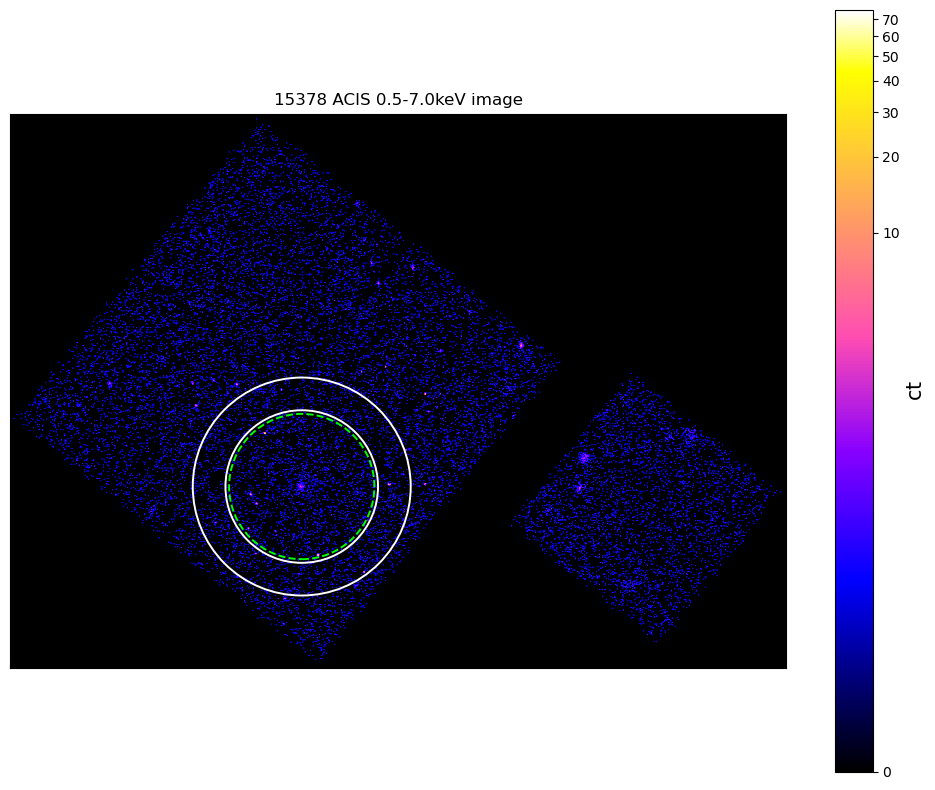

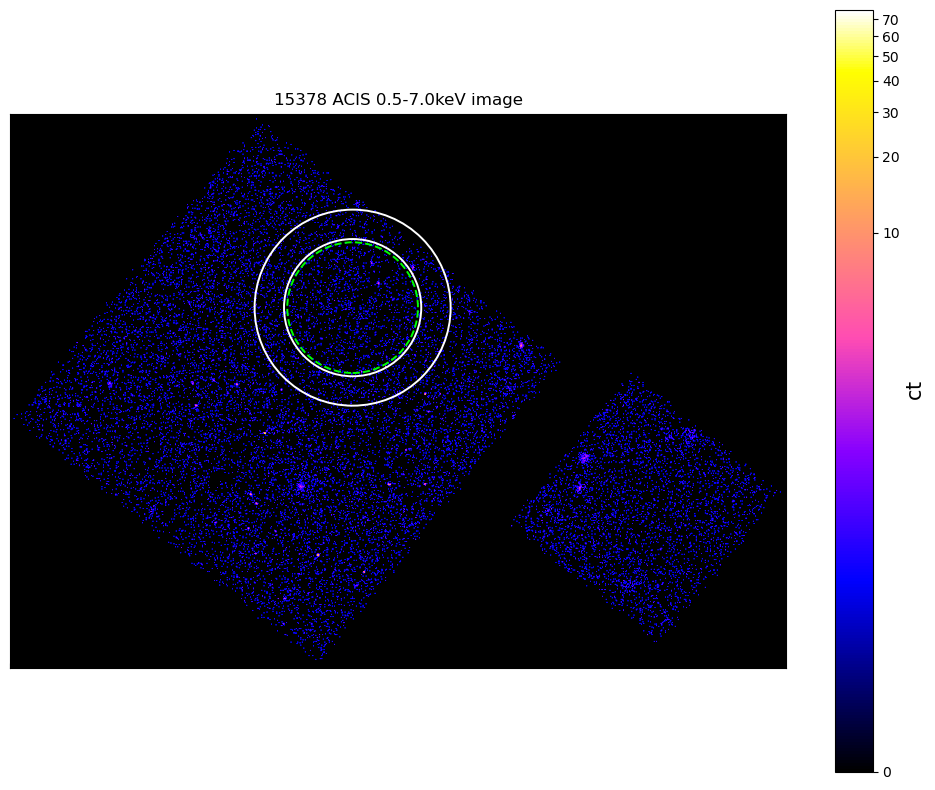

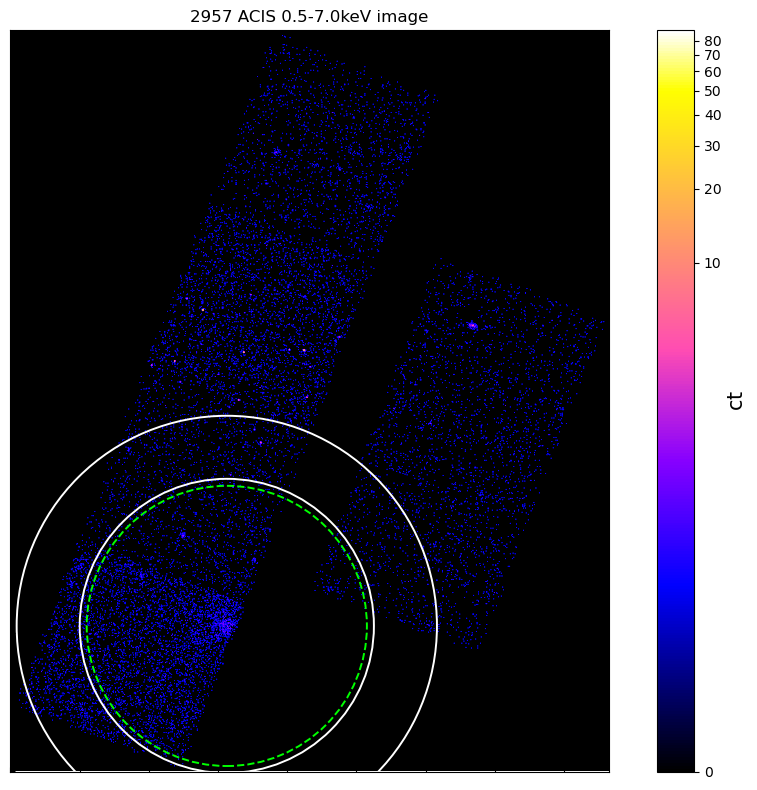

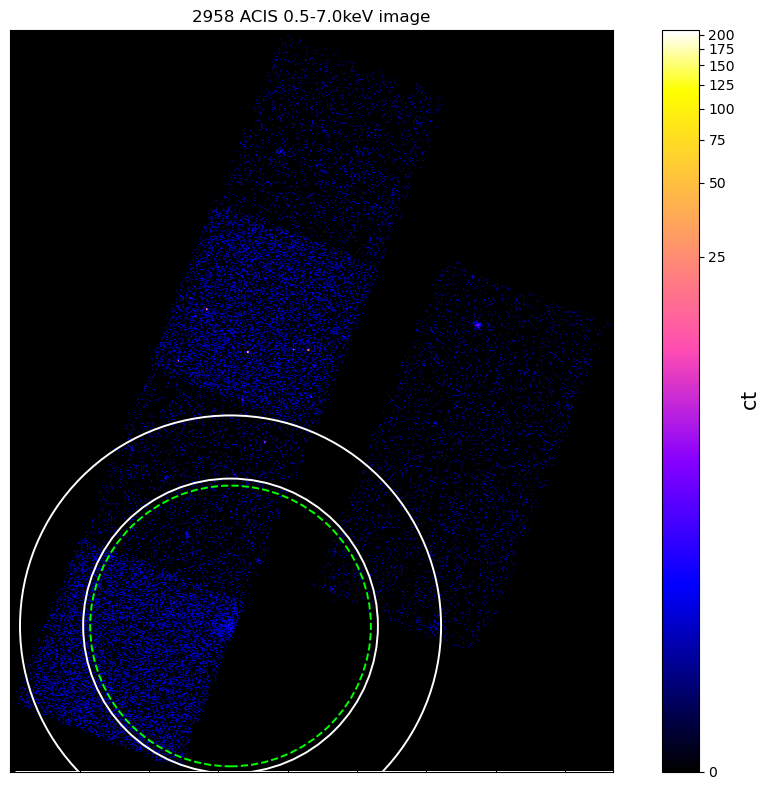

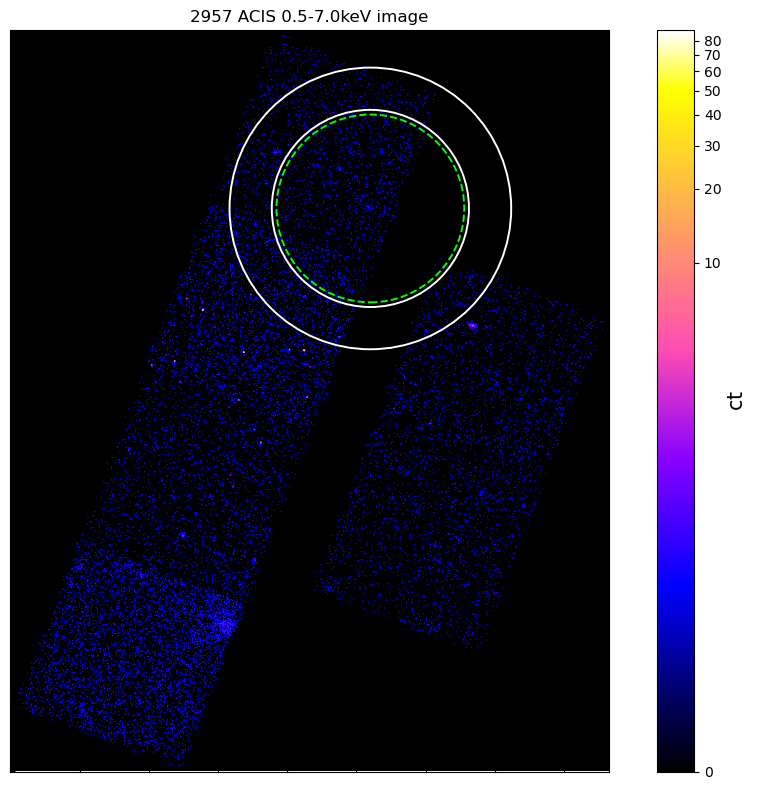

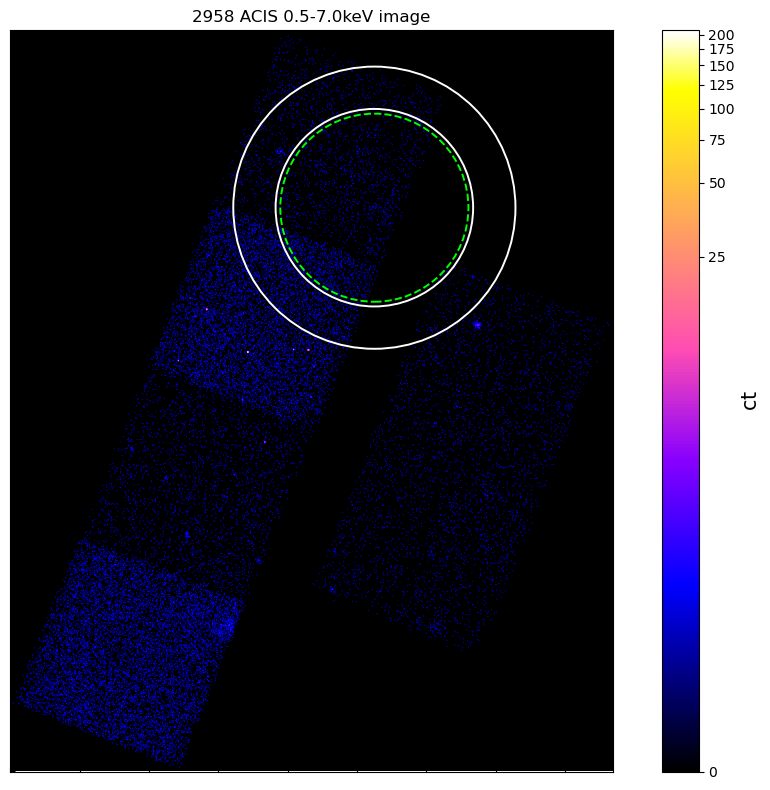

In [193]:
for src_name in rel_ch_reg_files:
    for oi in rel_ch_radec_reg_files[src_name]:
        # Grabbing the image we wish to view
        rel_im = rel_ch_rts[src_name][oi].image
        # Grabbing the VISUALISATION region file path
        rel_reg_file = rel_ch_radec_reg_files[src_name][oi]

        # This sidesteps a bug in XGA which will soon be fixed - adding RADec region files to the image
        #  requires a RA-DEC to pixel WCS is loaded, but it isn't being automatically loaded from the 
        #  file like it is meant to be - this call ensures that loading process has already happened
        rel_im.radec_wcs
        
        # Storing them in the image
        rel_im.regions = rel_reg_file
        # Viewing the image with the regions included
        rel_im.view(view_regions=True)
    print('\n\n')

### Generating spectra

Now that we've set up the region files that control what events we wish to include in our spectra, it is time to make them. Here we make use of the Python wrappings provided by Chandra's CIAO software - specifically the `specextract()` function, which is going to make all the spectra, RMFs, and ARFs, that we could possibly want.

In [ ]:
rel_ch_specs = {src_name: {} for src_name in rel_ch_obs}

for src_name in rel_ch_obs:
    rel_src = srcs[src_name]
    rel_ois = rel_ch_obs[src_name]
    
    for oi in rel_ois:
        
        reg_file = src_name + "-chandra-obsid{}".format(oi) + '-r500.reg'
        # r500_reg_out = os.path.join('../../outputs/reg_files/', reg_file)
        
        # TODO REMOVE THIS OBVIOUSLY
        r500_reg_out = reg_file

        # BACK REG
        back_reg_file = src_name + "-chandra-obsid{}".format(oi) + '-r500back.reg'
        # back_r500_reg_out = os.path.join('../../outputs/reg_files/', back_reg_file)
        
        # TODO REMOVE THIS OBVIOUSLY
        back_r500_reg_out = back_reg_file
        
        rel_evt_pth = evt_pth.format(oi=oi)
        copyfile(rel_evt_pth, 'testo.fits')
        # TEMP REG FILE
        filt_rel_evt = rel_evt_pth + "[sky=region({})]".format(reg_file)
        filt_rel_back_evt = rel_evt_pth + "[sky=region({})]".format(back_reg_file)

        asp_pth = os.path.join(root_pth, 'misc', 'obsid{oi}-instACIS-subexpE001-aspectsolution.fits').format(oi=oi)
        bpix_pth = os.path.join(root_pth, 'misc', 'obsid{oi}-instACIS-subexpE001-badpix.fits').format(oi=oi)

        # TODO EXTREMELY TEMPORARY
        # obsid15378-instACIS-subexpE001-badpix.fits
        msk_pth = "../../data/chandra_raw/{oi}/secondary/acisf{oi}_000N003_msk1.fits".format(oi=oi)

        # TODO CHANGE THIS WHEN THE FINAL PATHS ARE SET
        if not os.path.exists("testoo_grp.pi"):
            specextract(infile=filt_rel_evt, outroot='testoo', bkgfile=filt_rel_back_evt, bkgresp='no', asp=asp_pth, 
                        badpixfile=bpix_pth, mskfile=msk_pth, binspec=min_counts, bkg_grouptype='BIN_FILE', 
                        bkg_binspec="testoo_grp.pi", weight='yes', weight_rmf='yes', verbose=5, clobber=True, nproc=5)

        # TODO AGAIN UPDATE WHEN THERE IS A FINAL SPEC+ANC FILES PATH SET
        cur_sp = Spectrum("testoo_grp.pi", "testoo.rmf", "testoo.arf", "testoo_bkg.pi", rel_src.ra_dec, Quantity(0, 'deg'), 
                          cur_r500_deg, oi, 'ACIS', True, min_counts, None, None, None, '', '', '')
        cur_sp.src_name = rel_src.name

        # Store the spectrum instance in a dictionary for later (this will make setting up the XSPEC scripts a little easier)
        rel_ch_specs[src_name][oi] = cur_sp
        stop

## Fitting spectra

While we can't fit Chandra spectra directly through the XGA XSPEC interface yet, we can use the XGA XSPEC template script to make our life a little easier (and ensure that the fit process is identical to what we did for the XMM data):

In [148]:
xga.XSPEC_VERSION

In [147]:
for rel_name in rel_ch_specs:
    rel_src = srcs[rel_name]
    rel_sps = list(rel_ch_specs[rel_name].values())
    cur_script = "testoo.xcm"
    gen_xspec_script(rel_src, rel_sps, cur_script)
    stop
# gen_xspec_script()

NameError: name 'stop' is not defined